In [677]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

In [736]:
df = pd.read_csv('T_games_dataset.csv')

In [737]:
print(f'Number of rows: {len(df)}')
print(f'Unique clients: {len(df["client_id"].unique())}')

Number of rows: 88699
Unique clients: 41298


In [738]:
df['order_date'] = pd.to_datetime(df['order_day'])
df.drop('order_day', axis=1, inplace=True)
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['purchased_on_discount'] = df['category_name'] == 'Скидки'

df['good_type'] = df['good_name'].apply(
    lambda x: 'DLC' if 'dlc' in x.lower() else 'Game')
df['is_DLC'] = df['good_type'] == 'DLC'

bundle_tags = ['edition', 'pack', 'collection', 'bundle', 'antology']

df['is_bundle'] = df['good_name'].apply(lambda x: (any(tag in x.lower() for tag in bundle_tags)) and ('dlc' not in x.lower()))
bundle_purchases = df[df['is_bundle']].copy()
bundle_purchases['is_DLC'] = True
bundle_purchases['good_name'] = bundle_purchases['good_name'].apply(
    lambda x: x + ' (dlc from bundle)')
df = pd.concat([df, bundle_purchases], axis=0)

edu_lvl_grade = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu_lvl_by_grade = {v: k for k, v in edu_lvl_grade.items()}

df['edu_lvl_grade'] = df['education_level'].map(edu_lvl_grade)

min_age_by_id = df.groupby('client_id')['age'].min()
df['min_age'] = df['client_id'].map(min_age_by_id)

max_age_by_id = df.groupby('client_id')['age'].max()
df['max_age'] = df['client_id'].map(max_age_by_id)

highest_edu_lvl_by_id = df.groupby('client_id')['education_level'].apply(lambda x: edu_lvl_by_grade[x.map(edu_lvl_grade).max()])

df['edu_lvl_grade'] = df['client_id'].map(edu_lvl_grade)

count_genders_by_id = df.groupby('client_id').apply(lambda x : x['gender_cd'].nunique())

edu_lvls_by_id = df.groupby('client_id')['education_level'].apply(lambda x: x.drop_duplicates().tolist())

age_by_edu_lvl_treshold = {'SCH': 0, 'UGR': 16, 'GRD': 22, 'PGR': 26, 'ACD': 31}

## Очистка
Удаляем пользователей с разностью между минимальным и максимальным возрастом > 3 лет

Убираем строки с повторяющимися значениями (клиент, игра)

Образование берём максимальное у каждого клиента

In [739]:
df = df[df['max_age'] == df['min_age']]
df = df[df['age'] >= 14]
df = df[df['client_id'].map(count_genders_by_id) == 1]
df.drop_duplicates(subset=['client_id', 'good_name'], inplace=True)

client_ids = df['client_id'].drop_duplicates()

In [740]:
print(f'Number of rows: {len(df)}')
print(f'Unique clients: {len(client_ids)}')

Number of rows: 93159
Unique clients: 39990


In [741]:
def correct_edu_lvl(cliend_id):
    age = min_age_by_id[cliend_id]
    max_lvl = max([edu_lvl_grade[lvl] for lvl in edu_lvls_by_id[cliend_id]])
    while age < age_by_edu_lvl_treshold[edu_lvl_by_grade[max_lvl]]:
        max_lvl -= 1        
    return edu_lvl_by_grade[max_lvl]

df['education_level'] = df['client_id'].map(correct_edu_lvl)

In [742]:
mean_income_by_id = df.groupby('client_id')['monthly_income_amt'].mean()

min_income_by_id = df.groupby('client_id')['monthly_income_amt'].min()

age_by_id = df.groupby('client_id')['age'].min()

dlc_to_all_ratio_by_id = df.groupby('client_id')['is_DLC'].mean()

dlc_sum_by_id = df.groupby('client_id')['is_DLC'].sum()

count_by_id = df.groupby('client_id')['good_name'].count()

on_discount_by_id = df.groupby('client_id')['purchased_on_discount'].mean()

In [743]:
client_ids = client_ids[client_ids.map(min_income_by_id) > 0]

<AxesSubplot: >

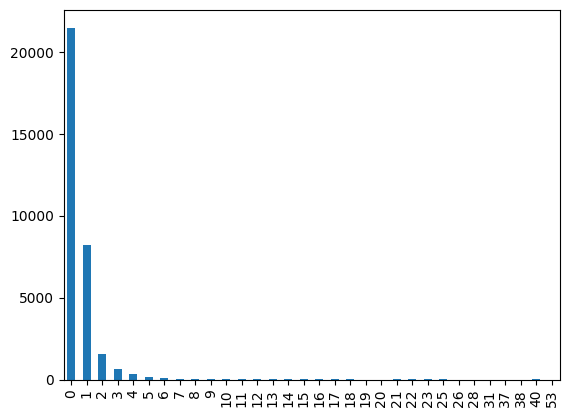

In [744]:
client_ids.map(dlc_sum_by_id).value_counts().sort_index().plot.bar()

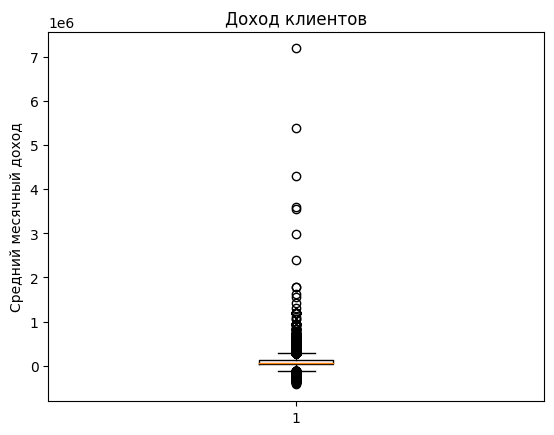

In [685]:
plt.boxplot(client_ids.map(mean_income_by_id))
plt.ylabel('Средний месячный доход')
plt.title('Доход клиентов')
plt.show()


In [686]:
left_treshold = client_ids.map(mean_income_by_id).quantile(0.01)
right_treshold = client_ids.map(mean_income_by_id).quantile(0.99)
client_ids = client_ids[client_ids.map(mean_income_by_id) > left_treshold]
client_ids = client_ids[client_ids.map(mean_income_by_id) < right_treshold]

In [687]:
print(f'Number of rows: {len(df)}')
print(f'Unique clients: {len(client_ids)}')

Number of rows: 93159
Unique clients: 39190


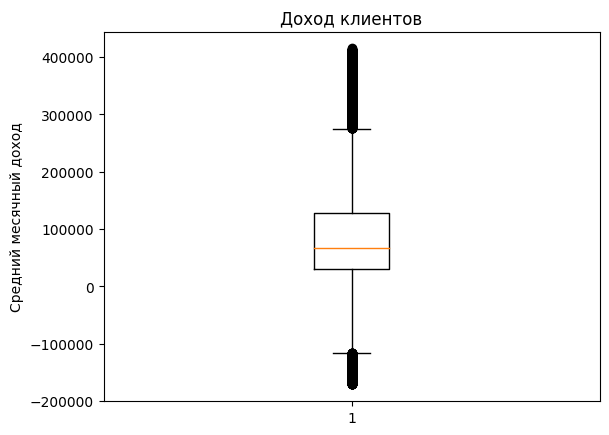

In [688]:
plt.boxplot(client_ids.map(mean_income_by_id))
plt.ylabel('Средний месячный доход')
plt.title('Доход клиентов')
plt.show()

<AxesSubplot: xlabel='discount'>

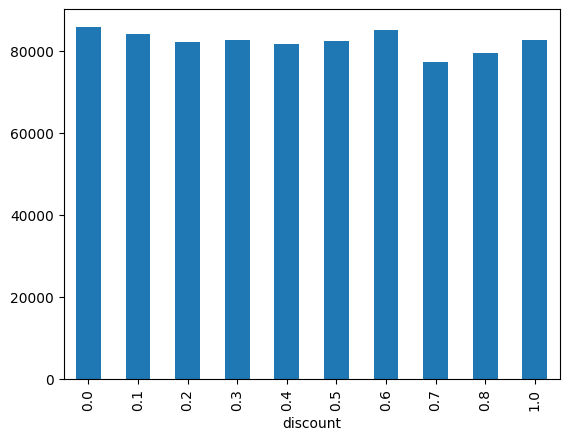

In [689]:
df1 = pd.DataFrame({'education_level': client_ids.map(correct_edu_lvl), 'discount': client_ids.map(on_discount_by_id).apply(lambda x : round(x, 1)), 'mean_income' : client_ids.map(mean_income_by_id), 'age': client_ids.map(age_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id), 'count': client_ids.map(count_by_id)})
df1.groupby('discount')['mean_income'].mean().plot.bar()

In [690]:
def plot_reg(x, y, precision=2, **kwargs):
    w1 = np.cov(x, y, ddof=0)[0, 1] / np.var(x, ddof=0)
    w0 = np.mean(y) - w1 * np.mean(x)
    plt.plot(x, w0 + w1 * x, color='red', label=f'y = {w0:.{precision}f} + x * {w1:.{precision}f}', **kwargs)
    plt.legend()

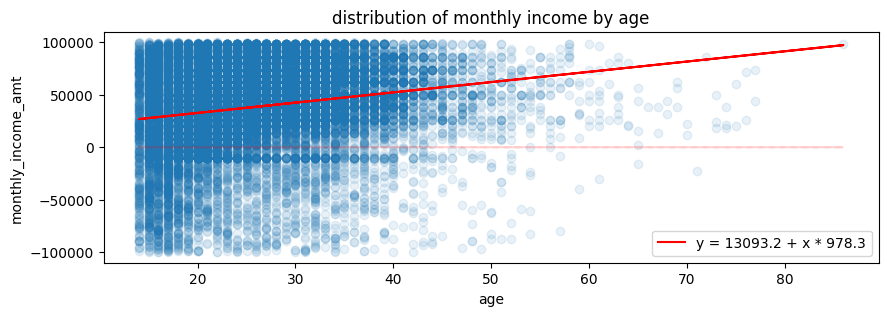

In [691]:
# plot distribution of monthly_income_amt by age
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'age' : client_ids.map(most_common_age_by_id), 'mean income' : client_ids.map(mean_income_by_id)})
df1 = df1[abs(df1['mean income']) < 100000]
plt.scatter(df1['age'], df1['mean income'], alpha=0.1)
plt.plot(df1['age'], np.zeros(df1.shape[0]), alpha=0.2, color='red', linestyle='--')
plt.xlabel('age')
plt.ylabel('monthly_income_amt')
plt.title('distribution of monthly income by age')
plot_reg(df1['age'], df1['mean income'], 1)

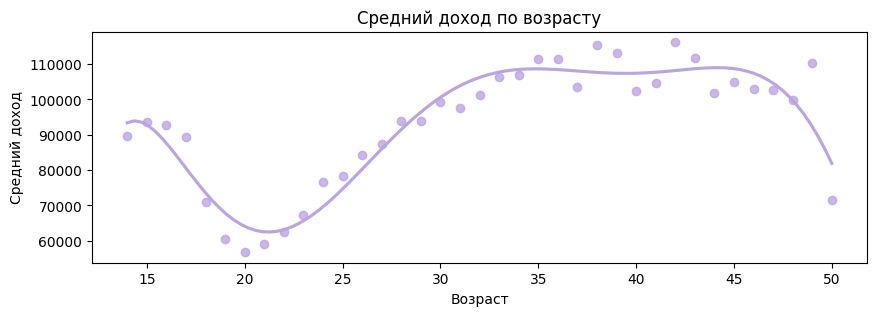

In [692]:
import seaborn as sns
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'age' : client_ids.map(most_common_age_by_id), 'mean income' : client_ids.map(mean_income_by_id)})
df1 = df1[(14 <= df1['age']) & (df1['age'] <= 50)]
df2 = df1.groupby('age')['mean income'].mean().reset_index()
sns.regplot(x='age', y='mean income', data=df2, order=7,
            ci=None, color='#bba5e1')
plt.xlabel('Возраст')
plt.ylabel('Средний доход')
plt.title('Средний доход по возрасту')
plt.show()

In [693]:
df.groupby(['client_id', 'good_name']).size().value_counts()

1    93159
dtype: int64

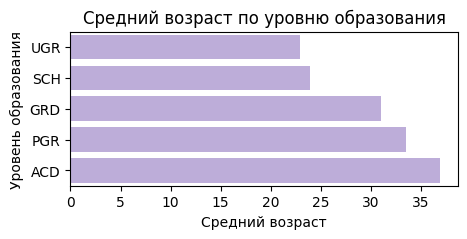

In [716]:
plt.figure(figsize=(5, 2))
df1 = pd.DataFrame({'age': client_ids.map(most_common_age_by_id), 'edu_lvl': client_ids.map(correct_edu_lvl)})
df2 = df1.groupby('edu_lvl')['age'].mean().sort_values().reset_index()

sns.barplot(x='age', y='edu_lvl', data=df2, color='#bba5e1')
plt.xlabel('Средний возраст')
plt.ylabel('Уровень образования')
plt.title('Средний возраст по уровню образования')
plt.show()

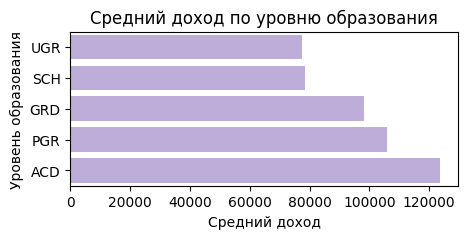

In [717]:
plt.figure(figsize=(5, 2))
df1 = pd.DataFrame({'edu_lvl': client_ids.map(correct_edu_lvl), 'monthly_income_amt': client_ids.map(mean_income_by_id)})
df2 = df1.groupby('edu_lvl')['monthly_income_amt'].mean().sort_values().reset_index()
sns.barplot(x='monthly_income_amt', y='edu_lvl', data=df2, color='#bba5e1')
plt.xlabel('Средний доход')
plt.ylabel('Уровень образования')
plt.title('Средний доход по уровню образования')
plt.show()

<AxesSubplot: xlabel='age', ylabel='dlc_to_all_ratio'>

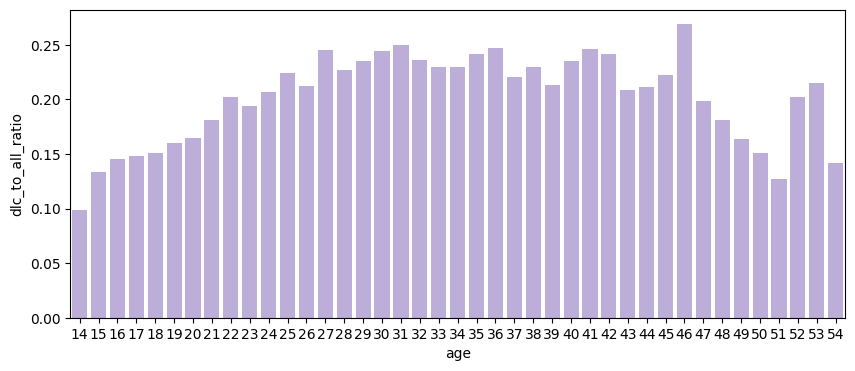

In [696]:
plt.figure(figsize=(10, 4))
df1 = pd.DataFrame({'age': client_ids.map(most_common_age_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
df1 = df1[(df1['age'] >= 14) & (df1['age'] < 55)]
df2 = df1.groupby('age')['dlc_to_all_ratio'].mean().reset_index()
sns.barplot(x='age', y='dlc_to_all_ratio', data=df2, color='#bba5e1')

Text(0, 0.5, 'Количество клиентов')

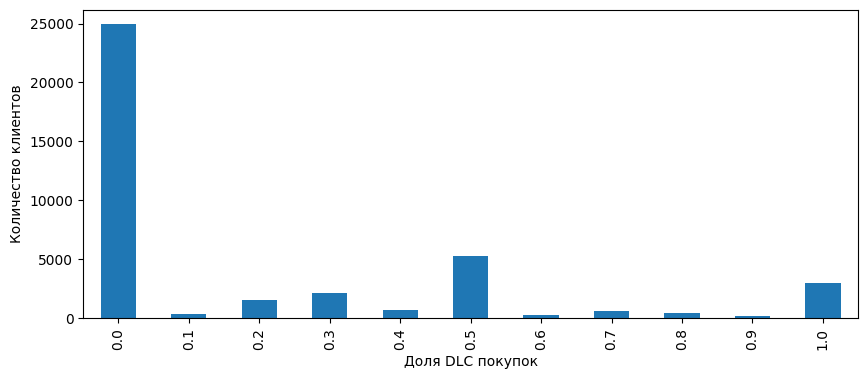

In [697]:
plt.figure(figsize=(10, 4))
df1 = pd.DataFrame({'age': client_ids.map(most_common_age_by_id),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
df1 = df1[(df1['age'] >= 14) & (df1['age'] < 55)]
df1['dlc_to_all_ratio'].apply(lambda x: round(x, 1)).value_counts().sort_index().plot(kind='bar')
plt.xlabel('Доля DLC покупок')
plt.ylabel('Количество клиентов')

<AxesSubplot: title={'center': 'Распределение количества покупок на клиента'}, xlabel='Количество покупок'>

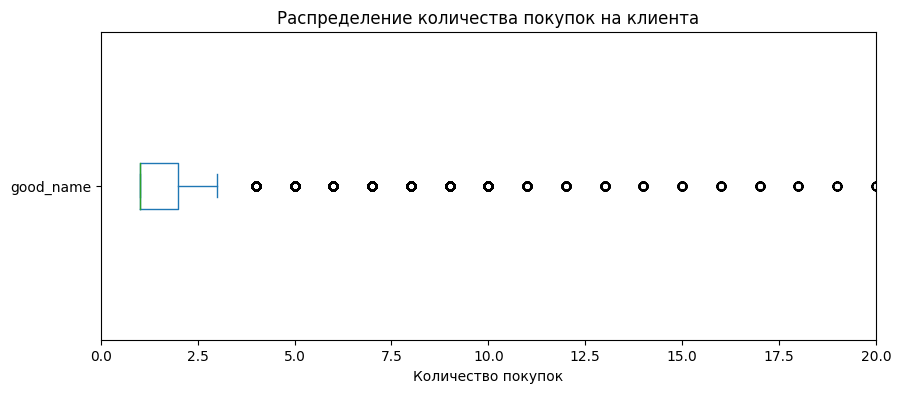

In [698]:
plt.figure(figsize=(10, 4))
count_by_id.plot(kind='box', vert=False, xlim=(0, 20), xlabel='Количество покупок', title='Распределение количества покупок на клиента')

In [726]:
count_by_id[count_by_id <= 3].sum() / count_by_id.sum()

0.5249734325185972

<AxesSubplot: xlabel='age', ylabel='count'>

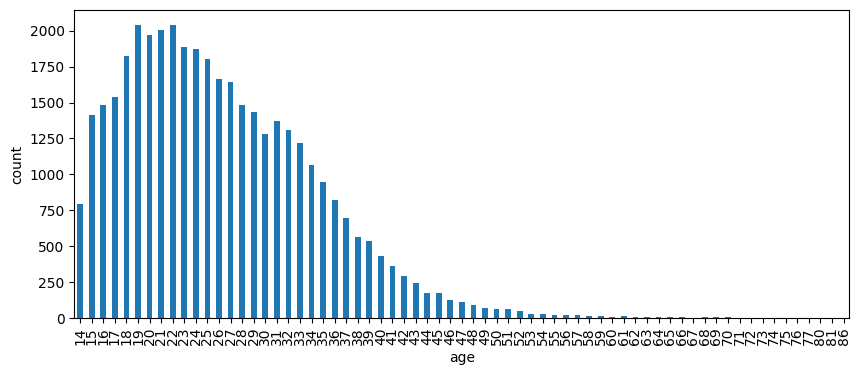

In [700]:
plt.figure(figsize=(10, 4))
client_ids.map(most_common_age_by_id).value_counts().sort_index().plot(kind='bar', xlabel='age', ylabel='count')

<AxesSubplot: xlabel='education level', ylabel='count'>

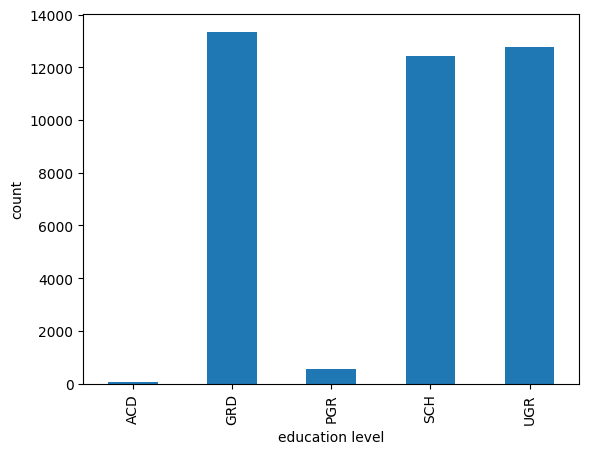

In [701]:
client_ids.map(correct_edu_lvl).value_counts().sort_index().plot(kind='bar', xlabel='education level', ylabel='count')

In [702]:
cnt_by_lvl = client_ids.map(correct_edu_lvl).value_counts()

In [703]:
cnt_by_lvl

GRD    13358
UGR    12784
SCH    12421
PGR      568
ACD       59
Name: client_id, dtype: int64

In [704]:
(cnt_by_lvl[3] + cnt_by_lvl[4]) / cnt_by_lvl.sum()

0.015998979331462108

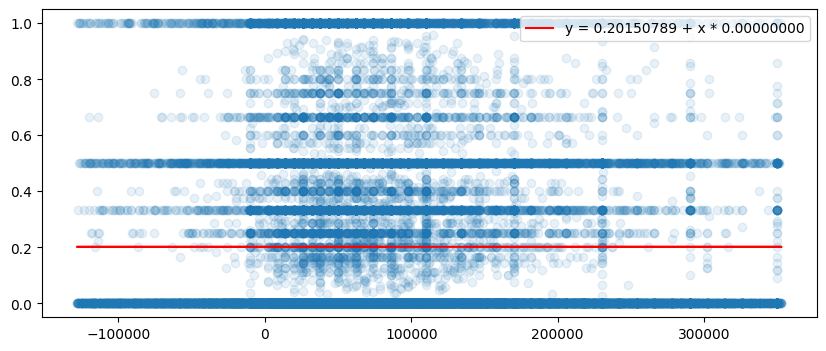

In [705]:
plt.figure(figsize=(10, 4))
df1 = pd.DataFrame({'income': client_ids.map(mean_income_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
treshold_left = df1['income'].quantile(0.01)
treshold_right = df1['income'].quantile(0.99)
df1 = df1[df1['income'] < treshold_right]
df1 = df1[df1['income'] > treshold_left]
plt.scatter(df1['income'], df1['dlc_to_all_ratio'], alpha=0.1)
plot_reg(df1['income'], df1['dlc_to_all_ratio'], 8)

In [706]:
incomes = client_ids.map(mean_income_by_id)
len(incomes[incomes < 0]) / len(incomes)

0.10839499872416433

In [707]:
df1 = pd.DataFrame({'income': client_ids.map(mean_income_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id), 'age': client_ids.map(most_common_age_by_id), 'edu_lvl': client_ids.map(highest_edu_lvl_by_id).apply(lambda x: edu_lvl_grade[x])})
# df1 = df1[(df1['age'] >= 14) & (df1['age'] < 40)]
df1.corr()

,income,dlc_to_all_ratio,age,edu_lvl
income,1.000000,0.002933,0.119054,0.074664
dlc_to_all_ratio,0.002933,1.000000,0.092357,0.053136
age,0.119054,0.092357,1.000000,0.089338
edu_lvl,0.074664,0.053136,0.089338,1.000000


<AxesSubplot: xlabel='mean dlc_to_all_ratio', ylabel='edu_lvl'>

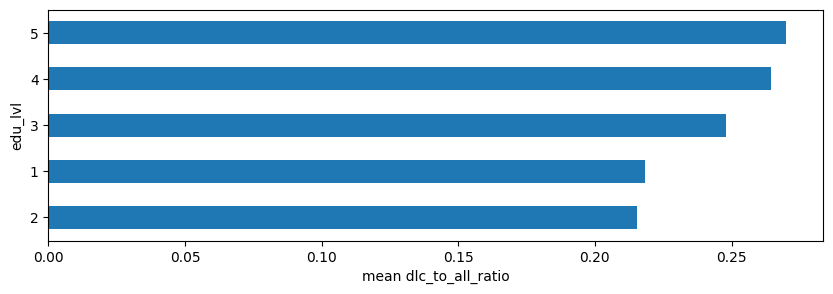

In [708]:
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id), 'edu_lvl' : client_ids.map(highest_edu_lvl_by_id).apply(lambda x: edu_lvl_grade[x]), 'age': client_ids.map(most_common_age_by_id)})
df1 = df1[(df1['age'] >= 27) & (df1['age'] < 45)]
df1.groupby('edu_lvl')['dlc_to_all_ratio'].mean().sort_values().plot(kind='barh', xlabel='mean dlc_to_all_ratio')

In [764]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import numpy as np

ids1 = client_ids[client_ids.map(min_age_by_id) >= 26]
ids1 = ids1[ids1.map(max_age_by_id) <= 50]

df1 = pd.DataFrame({'income': ids1.map(mean_income_by_id), 'dlc_to_all_ratio': ids1.map(dlc_to_all_ratio_by_id), 'age': ids1.map(most_common_age_by_id), 'edu_lvl': ids1.map(correct_edu_lvl).apply(lambda x: edu_lvl_grade[x]), 'count_purchases' : ids1.map(count_by_id)})
df1 = df1[df1['count_purchases'] > 3]
X = df1.drop('dlc_to_all_ratio', axis=1)
X = pd.get_dummies(X, columns=['edu_lvl'])
y = df1['dlc_to_all_ratio']

model = sm.OLS(y, sm.add_constant(X)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       dlc_to_all_ratio   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.907
Date:                Mon, 18 Dec 2023   Prob (F-statistic):             0.0646
Time:                        18:56:45   Log-Likelihood:                -144.87
No. Observations:                2167   AIC:                             305.7
Df Residuals:                    2159   BIC:                             351.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2923      0.034      8.707      0.000       0.226       0.358
income            3.77e-09      5e-08      0.075      0.940   -9.44e-08    1.02e-07
age                 0.0019      0.001      1.711      0.087      -0.000       0.004
count_purchases    -0.0014      0.000     -2.818      0.005      -0.002      -0.000
edu_lvl_1           0.0326      0.018      1.824      0.068      -0.002       0.068
edu_lvl_2           0.0595      0.019      3.182      0.001       0.023       0.096
edu_lvl_3           0.0562      0.015      3.679      0.000       0.026       0.086
edu_lvl_4           0.0624      0.025      2.503      0.012       0.014       0.111
edu_lvl_5           0.0816      0.060      1.356      0.175      -0.036       0.200
==============================================================================
Omnibus:                       98.118   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.941
Skew:                           0.516   Prob(JB):                     1.63e-23
Kurtosis:                       2.690   Cond. No.                     1.66e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [719]:
y.mean()

0.23407492791955287

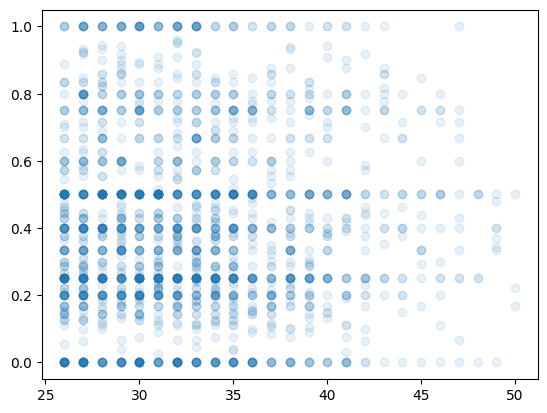

In [765]:
plt.scatter(X['age'],y, alpha=0.1)

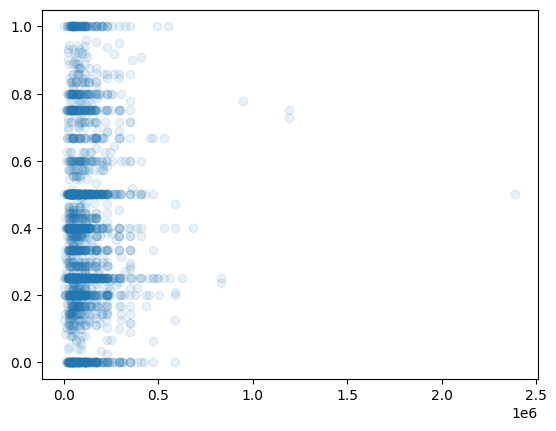

In [766]:
plt.scatter(X['income'], y, alpha=0.1)

In [775]:
import plotly.graph_objects as go

df1 = pd.DataFrame({'income': ids1.map(mean_income_by_id), 'dlc_ratio': ids1.map(dlc_to_all_ratio_by_id), 'age': ids1.map(most_common_age_by_id), 'edu_lvl' : ids1.map(correct_edu_lvl).apply(lambda x: edu_lvl_grade[x])})

df1 = df1[df1['income'] < 1e6]

fig = go.Figure(data=[go.Scatter3d(
    x=df1['income'],
    y=df1['age'],
    z=df1['edu_lvl'],
    mode='markers',
    marker=dict(
        size=5,
        color=df1['age'],
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis=dict(title='Income'),
        yaxis=dict(title='Age'),
        zaxis=dict(title='Education level')
    ),
    title='Interactive 3D Scatter Plot'
)

fig.show()
